In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
#from hf_olmo import OLMoTokenizerFast
import numpy as np
import os
from tqdm import tqdm, trange

model = 'gpt2-xl'
#model = 'Llama-2-7b'
# model = 'Olmo'
#model = 'pythia-6.9b-deduped'
#model = 'pythia-6.9b'
#model = 'Meta-Llama-3-8B'

    
dset_type = 'pos_logit'

In [ ]:
def convert_layer(index):
    index = index.split('.')[-1]
    try: 
        return int(index)
    except:
        if model == 'gpt2-xl':
            return 48
        return 32 # default value for final layer
    
def get_tokenizer(model_name):
    tokenizer = None
    if model_name == 'gpt2-xl':
        tokenizer = AutoTokenizer.from_pretrained('gpt2-xl')
    elif model_name == 'Llama-2-7b':
        tokenizer = AutoTokenizer.from_pretrained('Llama-2-7b-hf')
    elif model_name == 'pythia-6.9b-deduped' :
        tokenizer = AutoTokenizer.from_pretrained("pythia-6.9b-deduped")
    elif model_name == 'Meta-Llama-3-8B':
        tokenizer = AutoTokenizer.from_pretrained('Meta-Llama-3-8B')

    return tokenizer

def filter_df(pos_tag):
    path = f'out/data/{model}_{pos_tag}.csv'
    if not os.path.exists(path):
        print(f'{path} does not exist')
        return None

    new_df = pd.read_csv(path)
    new_df['layer'] = new_df['layer'].apply(convert_layer)
    new_df['type'] = pos_tag

    if 'answer_text' in new_df and new_df['answer_text'].notnull().all():
        new_df['answer_length'] = new_df['answer_text'].apply(lambda text : len(tokenizer.encode(str(text))) - 1)

    return new_df

output_df = []
tokenizer = get_tokenizer(model)
#pos_tags = ['QNA_tuned', 'QNA_second_tuned', 'QNA_third_tuned']
#pos_tags = ['MULTIQNA_tuned', 'MULTIQNA_second_tuned', 'MULTIQNA_third_tuned']
# pos_tags = ['REASONING', 'REASONING_second', 'REASONING_third']
#pos_tags = ['MMLU_tuned', 'SST_tuned', 'MRPC_tuned', 'NLI_tuned']
#pos_tags = ['DET_tuned', 'ADP_tuned', 'PUNCT_tuned', 'ADJ_tuned', 'VERB_tuned', 'NOUN_tuned']
pos_tags = ['DET_logit', 'ADP_logit', 'PUNCT_logit', 'ADJ_logit', 'VERB_logit', 'NOUN_logit']
#pos_tags = ['DET_tuned', 'ADP_tuned', 'VERB_tuned', 'BASELINE_tuned']
#pos_tags = ['ADP_tuned', 'CCONJ_tuned', 'DET_tuned', 'PART_tuned', 'ADV_tuned', 'AUX_tuned', 'PRON_tuned', 'SCONJ_tuned', 'PUNCT_tuned']
#pos_tags = ['ADP_tuned', 'CCONJ_tuned', 'DET_tuned', 'PART_tuned', 'SCONJ_tuned']
#pos_tags = ['AUX_tuned', 'PRON_tuned', 'PUNCT_tuned', 'ADV_tuned']
#pos_tags = ['REASONING_tuned', 'REASONING_second_tuned', 'REASONING_third_tuned', 'BASELINE_tuned']
# pos_tags = ['ADJ', 'DET', 'NOUN', 'VERB', 'FACT', 'BASELINE']
# pos_tags = ['ADJ_tuned', 'DET_tuned', 'NOUN_tuned', 'VERB_tuned', 'FACT_tuned', 'BASELINE_tuned']
# pos_tags = ['BASELINE']


In [6]:

for pos_tag in pos_tags: 
    output_df.append(filter_df(pos_tag))

output_df = pd.concat(output_df)

ANALYZE_MULTIPLE_TOKENS = False

if ANALYZE_MULTIPLE_TOKENS: 
    required_types = {
        1: pos_tags[:1],
        2: pos_tags[:2],
        3: pos_tags
    }
    dfs = []
    for length, types in required_types.items():
        dfs_for_length = [output_df[(output_df['answer_length'] == length) & (output_df['type'] == t)] for t in types]
        common_indices = set.intersection(*[set(df['prompt index']) for df in dfs_for_length])
        if common_indices:
            for i, df in enumerate(dfs_for_length):
                df = df[df['prompt index'].isin(common_indices)]
                df['type'] = f'{length} token answer token {i + 1}'
                dfs.append(df)
                
    dfs.append(filter_df('BASELINE_tuned'))
    dfs.append(filter_df('REASONING_-1'))
    output_df = pd.concat(dfs, ignore_index=True)

output_df.head(5)


,layer,prompt index,prompt,answer,answer_text,guess,rank,probability,type,answer_length
0,0,0,Humans lived in societies without formal hiera...,262,the,40048,9,0.003740,DET_logit,0.0
1,1,0,Humans lived in societies without formal hiera...,262,the,2462,9,0.002316,DET_logit,0.0
2,2,0,Humans lived in societies without formal hiera...,262,the,8978,3,0.003562,DET_logit,0.0
3,3,0,Humans lived in societies without formal hiera...,262,the,8978,4,0.004412,DET_logit,0.0
4,4,0,Humans lived in societies without formal hiera...,262,the,8978,2,0.004435,DET_logit,0.0


In [8]:
output_df['prompt index'].nunique()

12314

In [9]:

result = output_df[output_df['type'].notnull()].groupby('type')['prompt index'].nunique().reset_index()
result

,type,prompt index
0,ADJ_logit,2023
1,ADP_logit,5574
2,DET_logit,5563
3,NOUN_logit,3107
4,PUNCT_logit,4839
5,VERB_logit,2167


In [10]:
plot_df = []

# colors = {
#     '1 token answer token 1': ('blue', ()),
#     '2 token answer token 1': ('green', ()),
#     '2 token answer token 2': ('green', (5, 2, 1, 2)),
#     '3 token answer token 1': ('red', ()),
#     '3 token answer token 2': ('red', (5, 2)),
#     '3 token answer token 3': ('red', (1, 1)), 
#     'BASELINE_tuned': ('black', ()),
#     'REASONING_-1': ('purple', ())
# }

colors = { k : (sns.color_palette('hls', len(pos_tags))[i], ()) for i, k in enumerate(pos_tags)}

colors['BASELINE_tuned'] = ('black', ())

sample_points = np.unique(np.logspace(
    np.log10(1), np.log10(10001), num=200, dtype=int))

for type_label in colors.keys():
    color, linestyle = colors[type_label]
    df = output_df[output_df['type'] == type_label]
    for k in tqdm(sample_points):
        k_df = df[df['rank'] <= k]
        k_df = k_df.groupby('prompt index').first()['layer']
                
        if len(k_df) > 0:  
            plot_df.append({
                'k': k,
                'type': type_label,
                'average layer': np.average(k_df),
                'std layer': np.std(k_df)
            })

plot_df = pd.DataFrame(plot_df)



100%|██████████| 154/154 [00:00<00:00, 954.65it/s]


In [12]:
plot_df.to_csv(f'out/plot_data/{dset_type} _{model}_pos.csv', index=False)

#plot_df = pd.read_csv(f'out/plot_data/pos _{model}_pos.csv')

['DET_logit', 'ADP_logit', 'PUNCT_logit', 'ADJ_logit', 'VERB_logit', 'NOUN_logit']


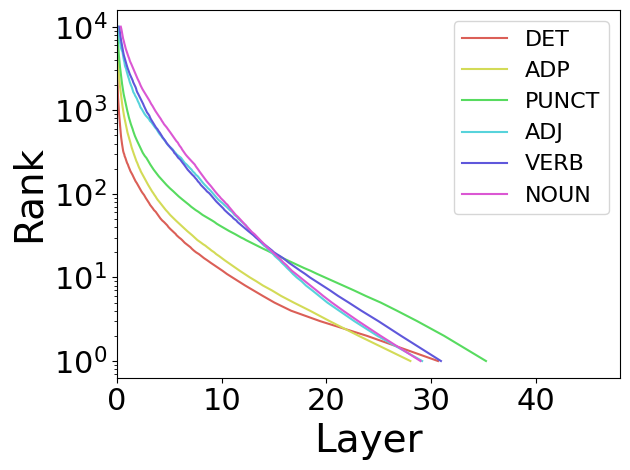

In [14]:
model_to_title = {
    'gpt2-xl': 'GPT2-XL',
    'Llama-2-7b': 'Llama2-7B',
    'pythia-6.9b-deduped': 'Pythia 6.9B',
    'pythia-6.9b': 'Pythia 6.9B',
    'Meta-Llama-3-8B':'Meta-Llama-3-8B'
}

model_to_xlim = {
    'gpt2-xl': 48,
    'Llama-2-7b': 32,
    'pythia-6.9b-deduped': 32,
    'pythia-6.9b': 32,
    'Meta-Llama-3-8B':32
}

x_tick_size = 22
y_tick_size = 22
x_lim = 1000
y_lim = 100
axis_fontsize = 28
legend_fontsize = 16

colors = { k : (sns.color_palette('hls', len(pos_tags))[i], ()) for i, k in enumerate(pos_tags)}
#colors['BASELINE_tuned'] = ('black', ())

std = 0.25

# Plot 2: Interchanged axes
# plt.figure(figsize=(6, 5))
# sns.lineplot(data=plot_df, x='average layer', y='k', hue='type', style='type',
#              palette={key: value[0] for key, value in colors.items()},
#              dashes={key: value[1] for key, value in colors.items()})

# for type_label in colors.keys():
#     sub_df = plot_df[plot_df['type'] == type_label]
#     y = sub_df['k'].to_numpy()
#     x1 = (sub_df['average layer'] - std * sub_df['std layer']).to_numpy()
#     x2 = (sub_df['average layer'] + std * sub_df['std layer']).to_numpy()
#     plt.fill_betweenx(y, x1, x2, alpha=0.2, color=colors[type_label][0])

for type_label in colors.keys():
    sub_df = plot_df[plot_df['type'] == type_label]
    y = sub_df['k'].to_numpy()
    x = sub_df['average layer'].to_numpy()  # Use just the mean (average layer) values
    plt.plot(x, y, color=colors[type_label][0], linestyle='-', label=type_label)  # Plot the mean values

plt.yscale('log')
plt.ylabel('Rank', fontsize=axis_fontsize)
plt.xlabel('Layer', fontsize=axis_fontsize)
plt.tick_params(axis='x', labelsize=x_tick_size)
plt.tick_params(axis='y', labelsize=y_tick_size)
#plt.title(model_to_title[model], fontsize=axis_fontsize - 4)
plt.xlim(0, model_to_xlim[model])

handles, labels = plt.gca().get_legend_handles_labels()
#####FOR FACT BASED ONLY
#labels_dict = {'REASONING_tuned': '1st token', 'REASONING_second_tuned': '2nd token', 'REASONING_third_tuned': '3rd token', 'BASELINE_tuned': 'BASELINE'}
print(labels)

new_labels = [label.split('_')[0] for label in labels]
plt.legend(handles=handles, labels=new_labels, title='', fontsize=legend_fontsize)

# current_xticks = plt.xticks()[0][:-1]  # Get current tick positions
# print(current_xticks)
# new_xticks = list(current_xticks) + [model_to_xlim[model]]  # Add your new tick
# plt.xticks(sorted(set(new_xticks))) 

plt.tight_layout()
plt.savefig(f'out/plots/{model}_{dset_type}.png')


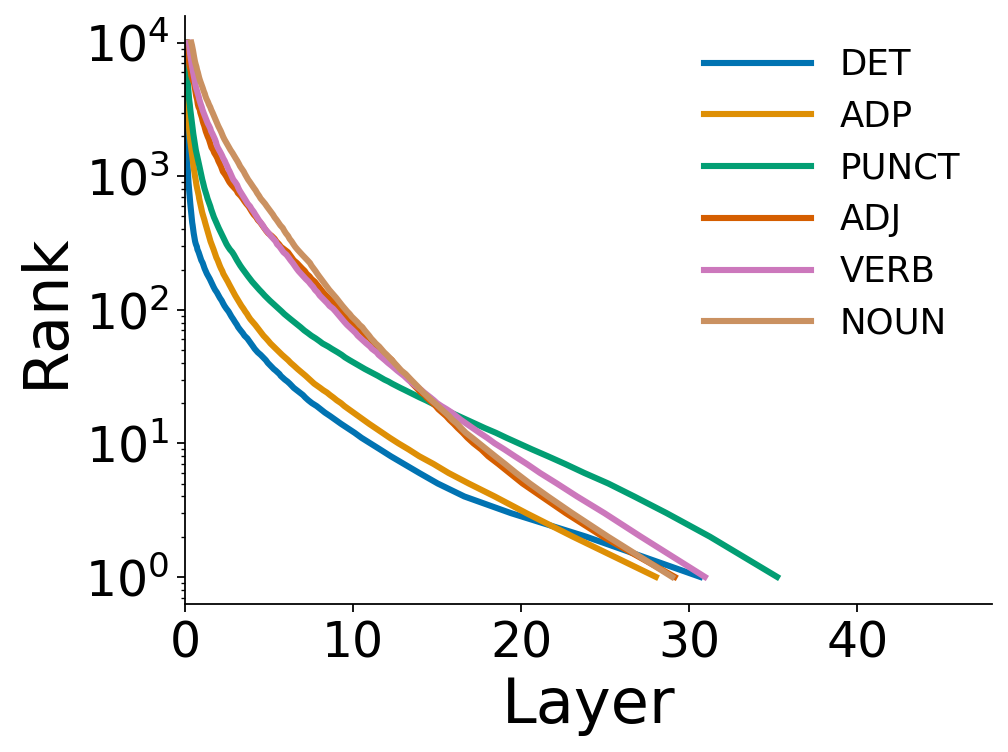

In [15]:
import matplotlib as mpl

# --- cosmetics only; no logic change ---
mpl.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 200,
    "axes.spines.top": False,    # axes exist, no top box
    "axes.spines.right": False,  # no right box
})

LINEWIDTH = 2.75  # thicker lines

def _base_label(lbl: str) -> str:
    # e.g., "REASONING_second_tuned" -> "REASONING"
    return lbl.split('_')[0]

def _style_for(lbl: str) -> str:
    low = lbl.lower()
    # first token solid, subsequent dotted
    if ("second" in low) or ("third" in low) or ("pos 2" in low) or ("pos 3" in low) or ("token 2" in low) or ("token 3" in low):
        return ":"
    return "-"

# Build shared colors per base group (1-, 2-, 3-token groups should already be encoded in your 'type' names' base prefix)
type_order = list(colors.keys())
groups_in_order = []
for t in type_order:
    b = _base_label(t)
    if b not in groups_in_order:
        groups_in_order.append(b)

palette = sns.color_palette("colorblind", n_colors=len(groups_in_order))
group_to_color = {g: palette[i] for i, g in enumerate(groups_in_order)}

# ---- Plot mean lines (same logic; just styling/colors) ----
for type_label in colors.keys():
    sub_df = plot_df[plot_df['type'] == type_label]
    y = sub_df['k'].to_numpy()
    x = sub_df['average layer'].to_numpy()  # mean only

    plt.plot(
        x, y,
        color=group_to_color[_base_label(type_label)],
        linestyle=_style_for(type_label),
        linewidth=LINEWIDTH,
        label=type_label
    )

plt.yscale('log')
plt.ylabel('Rank', fontsize=axis_fontsize)
plt.xlabel('Layer', fontsize=axis_fontsize)
plt.tick_params(axis='x', labelsize=x_tick_size)
plt.tick_params(axis='y', labelsize=y_tick_size)
# plt.title(model_to_title[model], fontsize=axis_fontsize - 4)
plt.xlim(0, model_to_xlim[model])

# Legend: show only the base label once (no counts), keep order of appearance
handles, labels = plt.gca().get_legend_handles_labels()
simple_labels = [_base_label(lab) for lab in labels]

unique_handles, unique_labels = [], []
seen = set()
for h, lab in zip(handles, simple_labels):
    if lab not in seen:
        unique_handles.append(h)
        unique_labels.append(lab)
        seen.add(lab)

plt.legend(handles=unique_handles, labels=unique_labels, title='', fontsize=legend_fontsize, frameon=False, handlelength=3)

plt.tight_layout()
plt.savefig(f'out/plots/{model}_{dset_type}.png', bbox_inches='tight')
